# **Machine Learning: Classification of tweets in Spanish using basic approach**

> **NLP Basic Approach - Spanish**



In this notebook we face a **binary text classification** problem to determinate if a Twitter user is a hate spreader or not. The possible labels in this case are **0 (not hate spreader)** or **1 (hate spreader)**.

The dataset used thoughout this code is available here: https://zenodo.org/record/4603578#.YMvUWmgzZPY

# **Load data**

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount("/content/drive/")
!ls 

Mounted at /content/drive/
drive  sample_data


Load the Author Profiling dataset from Google Drive path. This folder contais a total of 200 `xml` files in English and 200 `xml` files in Spanish, each one of them corresponding to an author (user of Twitter). Every file contains in turn 200 tweets of that user profile. What we are doing in this step, is to collect all this information into a single dataframe, with every row per author and two basic columns:


*   *label*: **0** if the author is not classified as hate spreader or **1** if it is.
*   *tweets*: This is a concatenation of all the 200 tweets of a single author into a text.





In [ ]:
# Home path where text file is stored
home_path = 'drive/My Drive/Colab Notebooks/Dataset/pan21-author-profiling-training-2021-03-14/'

# Text file to read
language = 'es'
data_files = home_path + language

In [ ]:
import os
import xml.etree.ElementTree as ET
import pandas as pd

# Dataframe to collect all the authors, their label and their tweets
df_cols = ['author', 'label', 'tweets']
df = pd.DataFrame(columns = df_cols)

# Read all the xml files
for filename in os.listdir(data_files):
  if not filename.endswith('.xml'): continue
  fullname = os.path.join(data_files, filename)
  root = ET.parse(fullname).getroot()
  author = filename.replace('.xml','') # Get author from the filename
  label = root.attrib.get("class") # Get class/label of that author
  tweets = ""
  for docs in root:
    for tweet in docs:
      tweets = tweets + " " + tweet.text # Combine all tweets of the same author
  df = df.append({'author': author, 'label': label, 'tweets': tweets}, ignore_index=True) # Add the author, its label and its tweets to the dataframe

df

,author,label,tweets
0,47fb97d3f4972fe326ec8f20d0b32004,1,Otra noche más... #USER# #USER# Yo también la...
1,409136cf62565da8a3fa385803dad035,1,RT #USER#: #USER# #USER# Eso demuestra que .....
2,6e3b4f88ca38d04437d315e3ec6e691f,1,RT #USER#: #USER# Asesinado por los mismos pe...
3,9ba85813abc8a8e5ba071d33a9a619a5,1,#USER# #USER# Es que estoy hablando con algui...
4,c2b7483d4f86610b7230ba2bf090bfbf,1,Debería estar tranquilo pero no estoy bienn t...
...,...,...,...
195,0af3ad19d2571df4cbca1948aba1019e,0,#USER# magnífico su resumen de esta semana 👏👏...
196,4c4a40070a6976a7b122e721b492b135,0,RT #USER#: Vox se querella contra Twitter por...
197,9feeee31ecafcc67fe5b3ba58f263c25,0,Bastante interesantes estas reflexiones sobre...
198,cf3ca531bb48f1f4aa47460ad925d3d0,0,#USER# #USER# Pero ponele algo más hombre #US...


In [ ]:
# Keep a copy of the original dataset without any modification
df_original = df.copy(deep = True)

# **Clean tweets**

In this section we are doing a preprocessing of all the texts in order to simplify the lexicon and remove symbols, characters or words which do not provide any information.
The steps perfomed are the following:
*   Convert all the text to **lower-case**.
*   Remove **urls**, **punctuation marks**, **emojis**, **symbols**, and **flags** between others.
*   Remove **stopwords** such as prepositions, articles or pronouns.
*   **Stemming** to reduce every word to its root form (*for example: walking → walk*).
*   Remove **words with less than 3 characters**, **numbers** or **digits**.





In [ ]:
import nltk
import re
import string
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# Select list of stopwords depending on the language
select_language = {
    'en': stopwords.words("english") + ['a', 'about', 'above', 'across', 'after', 'afterwards', 'again', 'against', 'all', 'almost', 'alone', 'along', 'already', 'also', 'although', 'always', 'am', 'among', 'amongst', 'amoungst', 'amount', 'an', 'and', 'another', 'any', 'anyhow', 'anyone', 'anything', 'anyway', 'anywhere', 'are', 'around', 'as', 'at', 'back', 'be', 'became', 'because', 'become', 'becomes', 'becoming', 'been', 'before', 'beforehand', 'behind', 'being', 'below', 'beside', 'besides', 'between', 'beyond', 'bill', 'both', 'bottom', 'but', 'by', 'call', 'can', 'cannot', 'cant', 'co', 'computer', 'con', 'could', 'couldnt', 'cry', 'de', 'describe', 'detail', 'do', 'done', 'down', 'due', 'during', 'each', 'eg', 'eight', 'either', 'eleven', 'else', 'elsewhere', 'empty', 'enough', 'etc', 'even', 'ever', 'every', 'everyone', 'everything', 'everywhere', 'except', 'few', 'fifteen', 'fify', 'fill', 'find', 'fire', 'first', 'five', 'for', 'former', 'formerly', 'forty', 'found', 'four', 'from', 'front', 'full', 'further', 'get', 'got', 'give', 'go', 'had', 'has', 'hasnt', 'have', 'he', 'hence', 'her', 'here', 'hereafter', 'hereby', 'herein', 'hereupon', 'hers', 'herself', 'him', 'himself', 'his', 'how', 'however', 'hundred', 'i', 'ie', 'if', 'in', 'inc', 'indeed', 'interest', 'into', 'is', 'it', 'its', 'itself', 'keep', 'last', 'latter', 'latterly', 'least', 'less', 'ltd', 'made', 'many', 'may', 'me', 'meanwhile', 'might', 'mill', 'mine', 'more', 'moreover', 'most', 'mostly', 'move', 'much', 'must', 'my', 'myself', 'name', 'namely', 'neither', 'never', 'nevertheless', 'next', 'nine', 'no', 'nobody', 'none', 'noone', 'nor', 'not', 'nothing', 'now', 'nowhere', 'of', 'off', 'often', 'on', 'once', 'one', 'only', 'onto', 'or', 'other', 'others', 'otherwise', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 'part', 'per', 'perhaps', 'please', 'put', 'rather', 're', 'same', 'see', 'seem', 'seemed', 'seeming', 'seems', 'serious', 'several', 'she', 'should', 'show', 'side', 'since', 'sincere', 'six', 'sixty', 'so', 'some', 'somehow', 'someone', 'something', 'sometime', 'sometimes', 'somewhere', 'still', 'such', 'system', 'take', 'ten', 'than', 'that', 'the', 'their', 'them', 'themselves', 'then', 'thence', 'there', 'thereafter', 'thereby', 'therefore', 'therein', 'thereupon', 'these', 'they', 'thick', 'thin', 'third', 'this', 'those', 'though', 'three', 'through', 'throughout', 'thru', 'thus', 'to', 'together', 'too', 'top', 'toward', 'towards', 'twelve', 'twenty', 'two', 'un', 'under', 'until', 'up', 'upon', 'us', 'very', 'via', 'was', 'we', 'well', 'were', 'what', 'whatever', 'when', 'whence', 'whenever', 'where', 'whereafter', 'whereas', 'whereby', 'wherein', 'whereupon', 'wherever', 'whether', 'which', 'while', 'whither', 'who', 'whoever', 'whole', 'whom', 'whose', 'why', 'will', 'with', 'within', 'without', 'would', 'yet', 'you', 'your', 'yours', 'yourself', 'yourselves'], 
    'es': stopwords.words("spanish")
}
stopwords_list = select_language.get(language) + ['user', 'rt', 'url', 'hashtag']

Following source codes have been used in order to implement the function `clean_tweets`:
*   https://github.com/isegura/BasicNLP/blob/master/TextClassification/SpamDetection.ipynb
*   https://www.kaggle.com/quentinsarrazin/tweets-preprocessing



In [ ]:
def clean_tweets(text):
  text = str(text).lower() # Text to lower-case

  # Remove urls, emojis, symbols...
  url = re.compile(r'https?://\S+|www\.\S+')
  html = re.compile(r'<.*?>')
  emoji_pattern = re.compile("["u"\U0001F1E6"u"\U0001F1E7"u"\U0001F1E8"u"\U0001F1E9"u"\U0001F1EA"u"\U0001F1EB"u"\U0001F1EC"u"\U0001F1ED"u"\U0001F1EE"u"\U0001F1EF"u"\U0001F1F0"u"\U0001F1F1"u"\U0001F1F2"u"\U0001F1F3"u"\U0001F1F4"u"\U0001F1F5"u"\U0001F1F6"u"\U0001F1F7"u"\U0001F1F8"u"\U0001F1F9"u"\U0001F1FA"u"\U0001F1FB"u"\U0001F1FC"u"\U0001F1FD"u"\U0001F1FE"u"\U0001F1FF"u"\U0001F201"u"\U0001F202"u"\U0001F21A"u"\U0001F22F"u"\U0001F232"u"\U0001F233"u"\U0001F234"u"\U0001F235"u"\U0001F236"u"\U0001F237"u"\U0001F238"u"\U0001F239"u"\U0001F23A"u"\U0001F250"u"\U0001F251"u"\U0001F300"u"\U0001F301"u"\U0001F302"u"\U0001F303"u"\U0001F304"u"\U0001F305"u"\U0001F306"u"\U0001F307"u"\U0001F308"u"\U0001F309"u"\U0001F30A"u"\U0001F30B"u"\U0001F30C"u"\U0001F30D"u"\U0001F30E"u"\U0001F30F"u"\U0001F310"u"\U0001F311"u"\U0001F312"u"\U0001F313"u"\U0001F314"u"\U0001F315"u"\U0001F316"u"\U0001F317"u"\U0001F318"u"\U0001F319"u"\U0001F31A"u"\U0001F31B"u"\U0001F31C"u"\U0001F31D"u"\U0001F31E"u"\U0001F31F"u"\U0001F320"u"\U0001F321"u"\U0001F324"u"\U0001F325"u"\U0001F326"u"\U0001F327"u"\U0001F328"u"\U0001F329"u"\U0001F32A"u"\U0001F32B"u"\U0001F32C"u"\U0001F32D"u"\U0001F32E"u"\U0001F32F"u"\U0001F330"u"\U0001F331"u"\U0001F332"u"\U0001F333"u"\U0001F334"u"\U0001F335"u"\U0001F336"u"\U0001F337"u"\U0001F338"u"\U0001F339"u"\U0001F33A"u"\U0001F33B"u"\U0001F33C"u"\U0001F33D"u"\U0001F33E"u"\U0001F33F"u"\U0001F340"u"\U0001F341"u"\U0001F342"u"\U0001F343"u"\U0001F344"u"\U0001F345"u"\U0001F346"u"\U0001F347"u"\U0001F348"u"\U0001F349"u"\U0001F34A"u"\U0001F34B"u"\U0001F34C"u"\U0001F34D"u"\U0001F34E"u"\U0001F34F"u"\U0001F350"u"\U0001F351"u"\U0001F352"u"\U0001F353"u"\U0001F354"u"\U0001F355"u"\U0001F356"u"\U0001F357"u"\U0001F358"u"\U0001F359"u"\U0001F35A"u"\U0001F35B"u"\U0001F35C"u"\U0001F35D"u"\U0001F35E"u"\U0001F35F"u"\U0001F360"u"\U0001F361"u"\U0001F362"u"\U0001F363"u"\U0001F364"u"\U0001F365"u"\U0001F366"u"\U0001F367"u"\U0001F368"u"\U0001F369"u"\U0001F36A"u"\U0001F36B"u"\U0001F36C"u"\U0001F36D"u"\U0001F36E"u"\U0001F36F"u"\U0001F370"u"\U0001F371"u"\U0001F372"u"\U0001F373"u"\U0001F374"u"\U0001F375"u"\U0001F376"u"\U0001F377"u"\U0001F378"u"\U0001F379"u"\U0001F37A"u"\U0001F37B"u"\U0001F37C"u"\U0001F37D"u"\U0001F37E"u"\U0001F37F"u"\U0001F380"u"\U0001F381"u"\U0001F382"u"\U0001F383"u"\U0001F384"u"\U0001F385"u"\U0001F386"u"\U0001F387"u"\U0001F388"u"\U0001F389"u"\U0001F38A"u"\U0001F38B"u"\U0001F38C"u"\U0001F38D"u"\U0001F38E"u"\U0001F38F"u"\U0001F390"u"\U0001F391"u"\U0001F392"u"\U0001F393"u"\U0001F396"u"\U0001F397"u"\U0001F399"u"\U0001F39A"u"\U0001F39B"u"\U0001F39E"u"\U0001F39F"u"\U0001F3A0"u"\U0001F3A1"u"\U0001F3A2"u"\U0001F3A3"u"\U0001F3A4"u"\U0001F3A5"u"\U0001F3A6"u"\U0001F3A7"u"\U0001F3A8"u"\U0001F3A9"u"\U0001F3AA"u"\U0001F3AB"u"\U0001F3AC"u"\U0001F3AD"u"\U0001F3AE"u"\U0001F3AF"u"\U0001F3B0"u"\U0001F3B1"u"\U0001F3B2"u"\U0001F3B3"u"\U0001F3B4"u"\U0001F3B5"u"\U0001F3B6"u"\U0001F3B7"u"\U0001F3B8"u"\U0001F3B9"u"\U0001F3BA"u"\U0001F3BB"u"\U0001F3BC"u"\U0001F3BD"u"\U0001F3BE"u"\U0001F3BF"u"\U0001F3C0"u"\U0001F3C1"u"\U0001F3C2"u"\U0001F3C3"u"\U0001F3C4"u"\U0001F3C5"u"\U0001F3C6"u"\U0001F3C7"u"\U0001F3C8"u"\U0001F3C9"u"\U0001F3CA"u"\U0001F3CB"u"\U0001F3CC"u"\U0001F3CD"u"\U0001F3CE"u"\U0001F3CF"u"\U0001F3D0"u"\U0001F3D1"u"\U0001F3D2"u"\U0001F3D3"u"\U0001F3D4"u"\U0001F3D5"u"\U0001F3D6"u"\U0001F3D7"u"\U0001F3D8"u"\U0001F3D9"u"\U0001F3DA"u"\U0001F3DB"u"\U0001F3DC"u"\U0001F3DD"u"\U0001F3DE"u"\U0001F3DF"u"\U0001F3E0"u"\U0001F3E1"u"\U0001F3E2"u"\U0001F3E3"u"\U0001F3E4"u"\U0001F3E5"u"\U0001F3E6"u"\U0001F3E7"u"\U0001F3E8"u"\U0001F3E9"u"\U0001F3EA"u"\U0001F3EB"u"\U0001F3EC"u"\U0001F3ED"u"\U0001F3EE"u"\U0001F3EF"u"\U0001F3F0"u"\U0001F3F3"u"\U0001F3F4"u"\U0001F3F5"u"\U0001F3F7"u"\U0001F3F8"u"\U0001F3F9"u"\U0001F3FA"u"\U0001F400"u"\U0001F401"u"\U0001F402"u"\U0001F403"u"\U0001F404"u"\U0001F405"u"\U0001F406"u"\U0001F407"u"\U0001F408"u"\U0001F409"u"\U0001F40A"u"\U0001F40B"u"\U0001F40C"u"\U0001F40D"u"\U0001F40E"u"\U0001F40F"u"\U0001F410"u"\U0001F411"u"\U0001F412"u"\U0001F413"u"\U0001F414"u"\U0001F415"u"\U0001F416"u"\U0001F417"u"\U0001F418"u"\U0001F419"u"\U0001F41A"u"\U0001F41B"u"\U0001F41C"u"\U0001F41D"u"\U0001F41E"u"\U0001F41F"u"\U0001F420"u"\U0001F421"u"\U0001F422"u"\U0001F423"u"\U0001F424"u"\U0001F425"u"\U0001F426"u"\U0001F427"u"\U0001F428"u"\U0001F429"u"\U0001F42A"u"\U0001F42B"u"\U0001F42C"u"\U0001F42D"u"\U0001F42E"u"\U0001F42F"u"\U0001F430"u"\U0001F431"u"\U0001F432"u"\U0001F433"u"\U0001F434"u"\U0001F435"u"\U0001F436"u"\U0001F437"u"\U0001F438"u"\U0001F439"u"\U0001F43A"u"\U0001F43B"u"\U0001F43C"u"\U0001F43D"u"\U0001F43E"u"\U0001F43F"u"\U0001F440"u"\U0001F441"u"\U0001F442"u"\U0001F443"u"\U0001F444"u"\U0001F445"u"\U0001F446"u"\U0001F447"u"\U0001F448"u"\U0001F449"u"\U0001F44A"u"\U0001F44B"u"\U0001F44C"u"\U0001F44D"u"\U0001F44E"u"\U0001F44F"u"\U0001F450"u"\U0001F451"u"\U0001F452"u"\U0001F453"u"\U0001F454"u"\U0001F455"u"\U0001F456"u"\U0001F457"u"\U0001F458"u"\U0001F459"u"\U0001F45A"u"\U0001F45B"u"\U0001F45C"u"\U0001F45D"u"\U0001F45E"u"\U0001F45F"u"\U0001F460"u"\U0001F461"u"\U0001F462"u"\U0001F463"u"\U0001F464"u"\U0001F465"u"\U0001F466"u"\U0001F467"u"\U0001F468"u"\U0001F469"u"\U0001F46A"u"\U0001F46B"u"\U0001F46C"u"\U0001F46D"u"\U0001F46E"u"\U0001F46F"u"\U0001F470"u"\U0001F471"u"\U0001F472"u"\U0001F473"u"\U0001F474"u"\U0001F475"u"\U0001F476"u"\U0001F477"u"\U0001F478"u"\U0001F479"u"\U0001F47A"u"\U0001F47B"u"\U0001F47C"u"\U0001F47D"u"\U0001F47E"u"\U0001F47F"u"\U0001F480"u"\U0001F481"u"\U0001F482"u"\U0001F483"u"\U0001F484"u"\U0001F485"u"\U0001F486"u"\U0001F487"u"\U0001F488"u"\U0001F489"u"\U0001F48A"u"\U0001F48B"u"\U0001F48C"u"\U0001F48D"u"\U0001F48E"u"\U0001F48F"u"\U0001F490"u"\U0001F491"u"\U0001F492"u"\U0001F493"u"\U0001F494"u"\U0001F495"u"\U0001F496"u"\U0001F497"u"\U0001F498"u"\U0001F499"u"\U0001F49A"u"\U0001F49B"u"\U0001F49C"u"\U0001F49D"u"\U0001F49E"u"\U0001F49F"u"\U0001F4A0"u"\U0001F4A1"u"\U0001F4A2"u"\U0001F4A3"u"\U0001F4A4"u"\U0001F4A5"u"\U0001F4A6"u"\U0001F4A7"u"\U0001F4A8"u"\U0001F4A9"u"\U0001F4AA"u"\U0001F4AB"u"\U0001F4AC"u"\U0001F4AD"u"\U0001F4AE"u"\U0001F4AF"u"\U0001F4B0"u"\U0001F4B1"u"\U0001F4B2"u"\U0001F4B3"u"\U0001F4B4"u"\U0001F4B5"u"\U0001F4B6"u"\U0001F4B7"u"\U0001F4B8"u"\U0001F4B9"u"\U0001F4BA"u"\U0001F4BB"u"\U0001F4BC"u"\U0001F4BD"u"\U0001F4BE"u"\U0001F4BF"u"\U0001F4C0"u"\U0001F4C1"u"\U0001F4C2"u"\U0001F4C3"u"\U0001F4C4"u"\U0001F4C5"u"\U0001F4C6"u"\U0001F4C7"u"\U0001F4C8"u"\U0001F4C9"u"\U0001F4CA"u"\U0001F4CB"u"\U0001F4CC"u"\U0001F4CD"u"\U0001F4CE"u"\U0001F4CF"u"\U0001F4D0"u"\U0001F4D1"u"\U0001F4D2"u"\U0001F4D3"u"\U0001F4D4"u"\U0001F4D5"u"\U0001F4D6"u"\U0001F4D7"u"\U0001F4D8"u"\U0001F4D9"u"\U0001F4DA"u"\U0001F4DB"u"\U0001F4DC"u"\U0001F4DD"u"\U0001F4DE"u"\U0001F4DF"u"\U0001F4E0"u"\U0001F4E1"u"\U0001F4E2"u"\U0001F4E3"u"\U0001F4E4"u"\U0001F4E5"u"\U0001F4E6"u"\U0001F4E7"u"\U0001F4E8"u"\U0001F4E9"u"\U0001F4EA"u"\U0001F4EB"u"\U0001F4EC"u"\U0001F4ED"u"\U0001F4EE"u"\U0001F4EF"u"\U0001F4F0"u"\U0001F4F1"u"\U0001F4F2"u"\U0001F4F3"u"\U0001F4F4"u"\U0001F4F5"u"\U0001F4F6"u"\U0001F4F7"u"\U0001F4F8"u"\U0001F4F9"u"\U0001F4FA"u"\U0001F4FB"u"\U0001F4FC"u"\U0001F4FD"u"\U0001F4FF"u"\U0001F500"u"\U0001F501"u"\U0001F502"u"\U0001F503"u"\U0001F504"u"\U0001F505"u"\U0001F506"u"\U0001F507"u"\U0001F508"u"\U0001F509"u"\U0001F50A"u"\U0001F50B"u"\U0001F50C"u"\U0001F50D"u"\U0001F50E"u"\U0001F50F"u"\U0001F510"u"\U0001F511"u"\U0001F512"u"\U0001F513"u"\U0001F514"u"\U0001F515"u"\U0001F516"u"\U0001F517"u"\U0001F518"u"\U0001F519"u"\U0001F51A"u"\U0001F51B"u"\U0001F51C"u"\U0001F51D"u"\U0001F51E"u"\U0001F51F"u"\U0001F520"u"\U0001F521"u"\U0001F522"u"\U0001F523"u"\U0001F524"u"\U0001F525"u"\U0001F526"u"\U0001F527"u"\U0001F528"u"\U0001F529"u"\U0001F52A"u"\U0001F52B"u"\U0001F52C"u"\U0001F52D"u"\U0001F52E"u"\U0001F52F"u"\U0001F530"u"\U0001F531"u"\U0001F532"u"\U0001F533"u"\U0001F534"u"\U0001F535"u"\U0001F536"u"\U0001F537"u"\U0001F538"u"\U0001F539"u"\U0001F53A"u"\U0001F53B"u"\U0001F53C"u"\U0001F53D"u"\U0001F549"u"\U0001F54A"u"\U0001F54B"u"\U0001F54C"u"\U0001F54D"u"\U0001F54E"u"\U0001F550"u"\U0001F551"u"\U0001F552"u"\U0001F553"u"\U0001F554"u"\U0001F555"u"\U0001F556"u"\U0001F557"u"\U0001F558"u"\U0001F559"u"\U0001F55A"u"\U0001F55B"u"\U0001F55C"u"\U0001F55D"u"\U0001F55E"u"\U0001F55F"u"\U0001F560"u"\U0001F561"u"\U0001F562"u"\U0001F563"u"\U0001F564"u"\U0001F565"u"\U0001F566"u"\U0001F567"u"\U0001F56F"u"\U0001F570"u"\U0001F573"u"\U0001F574"u"\U0001F575"u"\U0001F576"u"\U0001F577"u"\U0001F578"u"\U0001F579"u"\U0001F57A"u"\U0001F587"u"\U0001F58A"u"\U0001F58B"u"\U0001F58C"u"\U0001F58D"u"\U0001F590"u"\U0001F595"u"\U0001F596"u"\U0001F5A4"u"\U0001F5A5"u"\U0001F5A8"u"\U0001F5B1"u"\U0001F5B2"u"\U0001F5BC"u"\U0001F5C2"u"\U0001F5C3"u"\U0001F5C4"u"\U0001F5D1"u"\U0001F5D2"u"\U0001F5D3"u"\U0001F5DC"u"\U0001F5DD"u"\U0001F5DE"u"\U0001F5E1"u"\U0001F5E3"u"\U0001F5E8"u"\U0001F5EF"u"\U0001F5F3"u"\U0001F5FA"u"\U0001F5FB"u"\U0001F5FC"u"\U0001F5FD"u"\U0001F5FE"u"\U0001F5FF"u"\U0001F600"u"\U0001F601"u"\U0001F602"u"\U0001F603"u"\U0001F604"u"\U0001F605"u"\U0001F606"u"\U0001F607"u"\U0001F608"u"\U0001F609"u"\U0001F60A"u"\U0001F60B"u"\U0001F60C"u"\U0001F60D"u"\U0001F60E"u"\U0001F60F"u"\U0001F610"u"\U0001F611"u"\U0001F612"u"\U0001F613"u"\U0001F614"u"\U0001F615"u"\U0001F616"u"\U0001F617"u"\U0001F618"u"\U0001F619"u"\U0001F61A"u"\U0001F61B"u"\U0001F61C"u"\U0001F61D"u"\U0001F61E"u"\U0001F61F"u"\U0001F620"u"\U0001F621"u"\U0001F622"u"\U0001F623"u"\U0001F624"u"\U0001F625"u"\U0001F626"u"\U0001F627"u"\U0001F628"u"\U0001F629"u"\U0001F62A"u"\U0001F62B"u"\U0001F62C"u"\U0001F62D"u"\U0001F62E"u"\U0001F62F"u"\U0001F630"u"\U0001F631"u"\U0001F632"u"\U0001F633"u"\U0001F634"u"\U0001F635"u"\U0001F636"u"\U0001F637"u"\U0001F638"u"\U0001F639"u"\U0001F63A"u"\U0001F63B"u"\U0001F63C"u"\U0001F63D"u"\U0001F63E"u"\U0001F63F"u"\U0001F640"u"\U0001F641"u"\U0001F642"u"\U0001F643"u"\U0001F644"u"\U0001F645"u"\U0001F646"u"\U0001F647"u"\U0001F648"u"\U0001F649"u"\U0001F64A"u"\U0001F64B"u"\U0001F64C"u"\U0001F64D"u"\U0001F64E"u"\U0001F64F"u"\U0001F680"u"\U0001F681"u"\U0001F682"u"\U0001F683"u"\U0001F684"u"\U0001F685"u"\U0001F686"u"\U0001F687"u"\U0001F688"u"\U0001F689"u"\U0001F68A"u"\U0001F68B"u"\U0001F68C"u"\U0001F68D"u"\U0001F68E"u"\U0001F68F"u"\U0001F690"u"\U0001F691"u"\U0001F692"u"\U0001F693"u"\U0001F694"u"\U0001F695"u"\U0001F696"u"\U0001F697"u"\U0001F698"u"\U0001F699"u"\U0001F69A"u"\U0001F69B"u"\U0001F69C"u"\U0001F69D"u"\U0001F69E"u"\U0001F69F"u"\U0001F6A0"u"\U0001F6A1"u"\U0001F6A2"u"\U0001F6A3"u"\U0001F6A4"u"\U0001F6A5"u"\U0001F6A6"u"\U0001F6A7"u"\U0001F6A8"u"\U0001F6A9"u"\U0001F6AA"u"\U0001F6AB"u"\U0001F6AC"u"\U0001F6AD"u"\U0001F6AE"u"\U0001F6AF"u"\U0001F6B0"u"\U0001F6B1"u"\U0001F6B2"u"\U0001F6B3"u"\U0001F6B4"u"\U0001F6B5"u"\U0001F6B6"u"\U0001F6B7"u"\U0001F6B8"u"\U0001F6B9"u"\U0001F6BA"u"\U0001F6BB"u"\U0001F6BC"u"\U0001F6BD"u"\U0001F6BE"u"\U0001F6BF"u"\U0001F6C0"u"\U0001F6C1"u"\U0001F6C2"u"\U0001F6C3"u"\U0001F6C4"u"\U0001F6C5"u"\U0001F6CB"u"\U0001F6CC"u"\U0001F6CD"u"\U0001F6CE"u"\U0001F6CF"u"\U0001F6D0"u"\U0001F6D1"u"\U0001F6D2"u"\U0001F6D5"u"\U0001F6D6"u"\U0001F6D7"u"\U0001F6E0"u"\U0001F6E1"u"\U0001F6E2"u"\U0001F6E3"u"\U0001F6E4"u"\U0001F6E5"u"\U0001F6E9"u"\U0001F6EB"u"\U0001F6EC"u"\U0001F6F0"u"\U0001F6F3"u"\U0001F6F4"u"\U0001F6F5"u"\U0001F6F6"u"\U0001F6F7"u"\U0001F6F8"u"\U0001F6F9"u"\U0001F6FA"u"\U0001F6FB"u"\U0001F6FC"u"\U0001F7E0"u"\U0001F7E1"u"\U0001F7E2"u"\U0001F7E3"u"\U0001F7E4"u"\U0001F7E5"u"\U0001F7E6"u"\U0001F7E7"u"\U0001F7E8"u"\U0001F7E9"u"\U0001F7EA"u"\U0001F7EB"u"\U0001F90C"u"\U0001F90D"u"\U0001F90E"u"\U0001F90F"u"\U0001F910"u"\U0001F911"u"\U0001F912"u"\U0001F913"u"\U0001F914"u"\U0001F915"u"\U0001F916"u"\U0001F917"u"\U0001F918"u"\U0001F919"u"\U0001F91A"u"\U0001F91B"u"\U0001F91C"u"\U0001F91D"u"\U0001F91E"u"\U0001F91F"u"\U0001F920"u"\U0001F921"u"\U0001F922"u"\U0001F923"u"\U0001F924"u"\U0001F925"u"\U0001F926"u"\U0001F927"u"\U0001F928"u"\U0001F929"u"\U0001F92A"u"\U0001F92B"u"\U0001F92C"u"\U0001F92D"u"\U0001F92E"u"\U0001F92F"u"\U0001F930"u"\U0001F931"u"\U0001F932"u"\U0001F933"u"\U0001F934"u"\U0001F935"u"\U0001F936"u"\U0001F937"u"\U0001F938"u"\U0001F939"u"\U0001F93A"u"\U0001F93C"u"\U0001F93D"u"\U0001F93E"u"\U0001F93F"u"\U0001F940"u"\U0001F941"u"\U0001F942"u"\U0001F943"u"\U0001F944"u"\U0001F945"u"\U0001F947"u"\U0001F948"u"\U0001F949"u"\U0001F94A"u"\U0001F94B"u"\U0001F94C"u"\U0001F94D"u"\U0001F94E"u"\U0001F94F"u"\U0001F950"u"\U0001F951"u"\U0001F952"u"\U0001F953"u"\U0001F954"u"\U0001F955"u"\U0001F956"u"\U0001F957"u"\U0001F958"u"\U0001F959"u"\U0001F95A"u"\U0001F95B"u"\U0001F95C"u"\U0001F95D"u"\U0001F95E"u"\U0001F95F"u"\U0001F960"u"\U0001F961"u"\U0001F962"u"\U0001F963"u"\U0001F964"u"\U0001F965"u"\U0001F966"u"\U0001F967"u"\U0001F968"u"\U0001F969"u"\U0001F96A"u"\U0001F96B"u"\U0001F96C"u"\U0001F96D"u"\U0001F96E"u"\U0001F96F"u"\U0001F970"u"\U0001F971"u"\U0001F972"u"\U0001F973"u"\U0001F974"u"\U0001F975"u"\U0001F976"u"\U0001F977"u"\U0001F978"u"\U0001F97A"u"\U0001F97B"u"\U0001F97C"u"\U0001F97D"u"\U0001F97E"u"\U0001F97F"u"\U0001F980"u"\U0001F981"u"\U0001F982"u"\U0001F983"u"\U0001F984"u"\U0001F985"u"\U0001F986"u"\U0001F987"u"\U0001F988"u"\U0001F989"u"\U0001F98A"u"\U0001F98B"u"\U0001F98C"u"\U0001F98D"u"\U0001F98E"u"\U0001F98F"u"\U0001F990"u"\U0001F991"u"\U0001F992"u"\U0001F993"u"\U0001F994"u"\U0001F995"u"\U0001F996"u"\U0001F997"u"\U0001F998"u"\U0001F999"u"\U0001F99A"u"\U0001F99B"u"\U0001F99C"u"\U0001F99D"u"\U0001F99E"u"\U0001F99F"u"\U0001F9A0"u"\U0001F9A1"u"\U0001F9A2"u"\U0001F9A3"u"\U0001F9A4"u"\U0001F9A5"u"\U0001F9A6"u"\U0001F9A7"u"\U0001F9A8"u"\U0001F9A9"u"\U0001F9AA"u"\U0001F9AB"u"\U0001F9AC"u"\U0001F9AD"u"\U0001F9AE"u"\U0001F9AF"u"\U0001F9B0"u"\U0001F9B1"u"\U0001F9B2"u"\U0001F9B3"u"\U0001F9B4"u"\U0001F9B5"u"\U0001F9B6"u"\U0001F9B7"u"\U0001F9B8"u"\U0001F9B9"u"\U0001F9BA"u"\U0001F9BB"u"\U0001F9BC"u"\U0001F9BD"u"\U0001F9BE"u"\U0001F9BF"u"\U0001F9C0"u"\U0001F9C1"u"\U0001F9C2"u"\U0001F9C3"u"\U0001F9C4"u"\U0001F9C5"u"\U0001F9C6"u"\U0001F9C7"u"\U0001F9C8"u"\U0001F9C9"u"\U0001F9CA"u"\U0001F9CB"u"\U0001F9CD"u"\U0001F9CE"u"\U0001F9CF"u"\U0001F9D0"u"\U0001F9D1"u"\U0001F9D2"u"\U0001F9D3"u"\U0001F9D4"u"\U0001F9D5"u"\U0001F9D6"u"\U0001F9D7"u"\U0001F9D8"u"\U0001F9D9"u"\U0001F9DA"u"\U0001F9DB"u"\U0001F9DC"u"\U0001F9DD"u"\U0001F9DE"u"\U0001F9DF"u"\U0001F9E0"u"\U0001F9E1"u"\U0001F9E2"u"\U0001F9E3"u"\U0001F9E4"u"\U0001F9E5"u"\U0001F9E6"u"\U0001F9E7"u"\U0001F9E8"u"\U0001F9E9"u"\U0001F9EA"u"\U0001F9EB"u"\U0001F9EC"u"\U0001F9ED"u"\U0001F9EE"u"\U0001F9EF"u"\U0001F9F0"u"\U0001F9F1"u"\U0001F9F2"u"\U0001F9F3"u"\U0001F9F4"u"\U0001F9F5"u"\U0001F9F6"u"\U0001F9F7"u"\U0001F9F8"u"\U0001F9F9"u"\U0001F9FA"u"\U0001F9FB"u"\U0001F9FC"u"\U0001F9FD"u"\U0001F9FE"u"\U0001F9FF"u"\U0001FA70"u"\U0001FA71"u"\U0001FA72"u"\U0001FA73"u"\U0001FA74"u"\U0001FA78"u"\U0001FA79"u"\U0001FA7A"u"\U0001FA80"u"\U0001FA81"u"\U0001FA82"u"\U0001FA83"u"\U0001FA84"u"\U0001FA85"u"\U0001FA86"u"\U0001FA90"u"\U0001FA91"u"\U0001FA92"u"\U0001FA93"u"\U0001FA94"u"\U0001FA95"u"\U0001FA96"u"\U0001FA97"u"\U0001FA98"u"\U0001FA99"u"\U0001FA9A"u"\U0001FA9B"u"\U0001FA9C"u"\U0001FA9D"u"\U0001FA9E"u"\U0001FA9F"u"\U0001FAA0"u"\U0001FAA1"u"\U0001FAA2"u"\U0001FAA3"u"\U0001FAA4"u"\U0001FAA5"u"\U0001FAA6"u"\U0001FAA7"u"\U0001FAA8"u"\U0001FAB0"u"\U0001FAB1"u"\U0001FAB2"u"\U0001FAB3"u"\U0001FAB4"u"\U0001FAB5"u"\U0001FAB6"u"\U0001FAC0"u"\U0001FAC1"u"\U0001FAC2"u"\U0001FAD0"u"\U0001FAD1"u"\U0001FAD2"u"\U0001FAD3"u"\U0001FAD4"u"\U0001FAD5"u"\U0001FAD6"u"\U0000200D"u"\U0000203C"u"\U00002049"u"\U00002122"u"\U00002139"u"\U00002194"u"\U00002195"u"\U00002196"u"\U00002197"u"\U00002198"u"\U00002199"u"\U000021A9"u"\U000021AA"u"\U0000231A"u"\U0000231B"u"\U00002328"u"\U000023CF"u"\U000023E9"u"\U000023EA"u"\U000023EB"u"\U000023EC"u"\U000023ED"u"\U000023EE"u"\U000023EF"u"\U000023F0"u"\U000023F1"u"\U000023F2"u"\U000023F3"u"\U000023F8"u"\U000023F9"u"\U000023FA"u"\U000024C2"u"\U000025AA"u"\U000025AB"u"\U000025B6"u"\U000025C0"u"\U000025FB"u"\U000025FC"u"\U000025FD"u"\U000025FE"u"\U00002600"u"\U00002601"u"\U00002602"u"\U00002603"u"\U00002604"u"\U0000260E"u"\U00002611"u"\U00002614"u"\U00002615"u"\U00002618"u"\U0000261D"u"\U00002620"u"\U00002622"u"\U00002623"u"\U00002626"u"\U0000262A"u"\U0000262E"u"\U0000262F"u"\U00002638"u"\U00002639"u"\U0000263A"u"\U00002640"u"\U00002642"u"\U00002648"u"\U00002649"u"\U0000264A"u"\U0000264B"u"\U0000264C"u"\U0000264D"u"\U0000264E"u"\U0000264F"u"\U00002650"u"\U00002651"u"\U00002652"u"\U00002653"u"\U0000265F"u"\U00002660"u"\U00002663"u"\U00002665"u"\U00002666"u"\U00002668"u"\U0000267B"u"\U0000267E"u"\U0000267F"u"\U00002692"u"\U00002693"u"\U00002694"u"\U00002695"u"\U00002696"u"\U00002697"u"\U00002699"u"\U0000269B"u"\U0000269C"u"\U000026A0"u"\U000026A1"u"\U000026A7"u"\U000026AA"u"\U000026AB"u"\U000026B0"u"\U000026B1"u"\U000026BD"u"\U000026BE"u"\U000026C4"u"\U000026C5"u"\U000026C8"u"\U000026CE"u"\U000026CF"u"\U000026D1"u"\U000026D3"u"\U000026D4"u"\U000026E9"u"\U000026EA"u"\U000026F0"u"\U000026F1"u"\U000026F2"u"\U000026F3"u"\U000026F4"u"\U000026F5"u"\U000026F7"u"\U000026F8"u"\U000026F9"u"\U000026FA"u"\U000026FD"u"\U00002702"u"\U00002705"u"\U00002708"u"\U00002709"u"\U0000270A"u"\U0000270B"u"\U0000270C"u"\U0000270D"u"\U0000270F"u"\U00002712"u"\U00002714"u"\U00002716"u"\U0000271D"u"\U00002721"u"\U00002728"u"\U00002733"u"\U00002734"u"\U00002744"u"\U00002747"u"\U0000274C"u"\U0000274E"u"\U00002753"u"\U00002754"u"\U00002755"u"\U00002757"u"\U00002763"u"\U00002764"u"\U00002795"u"\U00002796"u"\U00002797"u"\U000027A1"u"\U000027B0"u"\U000027BF"u"\U00002934"u"\U00002935"u"\U00002B05"u"\U00002B06"u"\U00002B07"u"\U00002B1B"u"\U00002B1C"u"\U00002B50"u"\U00002B55"u"\U00003030"u"\U0000303D"u"\U00003297"u"\U00003299"u"\U0000FE0F"u"\U000E0063"u"\U000E0065"u"\U000E0067"u"\U000E006C"u"\U000E006E"u"\U000E0073"u"\U000E0074"u"\U000E0077"u"\U000E007F"u"\U0000FE0F"
"]+", flags=re.UNICODE)
  table = str.maketrans('','',string.punctuation)
    
  text = url.sub(r'',text)
  text = html.sub(r'',text)
  text = emoji_pattern.sub(r'', text)
  text = text.translate(table)
  
  # Tokenize the remaining text and remove stopwords
  tokens = [word for word in word_tokenize(text) if word not in stopwords_list]
  
  # Get the stem of every word (token)
  tokens = [PorterStemmer().stem(word) for word in tokens]
  
  # Remove words with less than 3 letters and words that contain numbers, punctuation,...
  min_length = 3
  p = re.compile('[a-zA-Z]+');
  filtered_tokens = []
  for token in tokens:
      if len(token) >= min_length and p.match(token):
          filtered_tokens.append(token)

  return filtered_tokens

In [ ]:
df['tweets'] = df['tweets'].apply(lambda x : clean_tweets(x))

for i in range(0,len(df)):
  df['tweets'][i] = ' '.join(map(str, df['tweets'][i]))
df

,author,label,tweets
0,47fb97d3f4972fe326ec8f20d0b32004,1,noch quiero natanael diosito llega hora gana m...
1,409136cf62565da8a3fa385803dad035,1,demuestra escuec ladranluego cabalgamo hora ll...
2,6e3b4f88ca38d04437d315e3ec6e691f,1,asesinado mismo peruca cínico hdrmp udsson lie...
3,9ba85813abc8a8e5ba071d33a9a619a5,1,hablando alguien trave escribir bueno mismo bu...
4,c2b7483d4f86610b7230ba2bf090bfbf,1,debería tranquilo bienn sacarm basura puta sie...
...,...,...,...
195,0af3ad19d2571df4cbca1948aba1019e,0,magnífico resumen semana buena noch buen desca...
196,4c4a40070a6976a7b122e721b492b135,0,vox querella twitter censurar campaña islamiza...
197,9feeee31ecafcc67fe5b3ba58f263c25,0,bastant interesant reflexion cómo gestionar re...
198,cf3ca531bb48f1f4aa47460ad925d3d0,0,ponel hombr malparido juego malo cáncer noti b...


# **Word Cloud**

After preprocessing, we may want to know the most common words in the whole dataset of tweets, specially those of them which belong to authors classified as hate spreaders. Most of these words will probably help in the task of classification into one label or another.

In [ ]:
from collections import Counter

# Filter authors with label = 1
cleaned_tweets = df[df.label == "1"]['tweets'].map(clean_tweets).tolist()

# Show most common words in the tweets of these authors
words = [item for sublist in cleaned_tweets for item in sublist]
Counter(words).most_common(30)

[('día', 608),
 ('ser', 469),
 ('españa', 457),
 ('año', 434),
 ('así', 414),
 ('bien', 385),
 ('mejor', 373),
 ('hace', 360),
 ('gobierno', 353),
 ('hoy', 337),
 ('mujer', 325),
 ('pue', 321),
 ('solo', 318),
 ('gracia', 311),
 ('bueno', 304),
 ('madrid', 304),
 ('ver', 303),
 ('ahora', 301),
 ('siempr', 299),
 ('mierda', 283),
 ('gent', 282),
 ('toda', 266),
 ('verdad', 247),
 ('meno', 243),
 ('mismo', 242),
 ('hombr', 235),
 ('vida', 235),
 ('puta', 232),
 ('hacer', 229),
 ('dice', 227)]

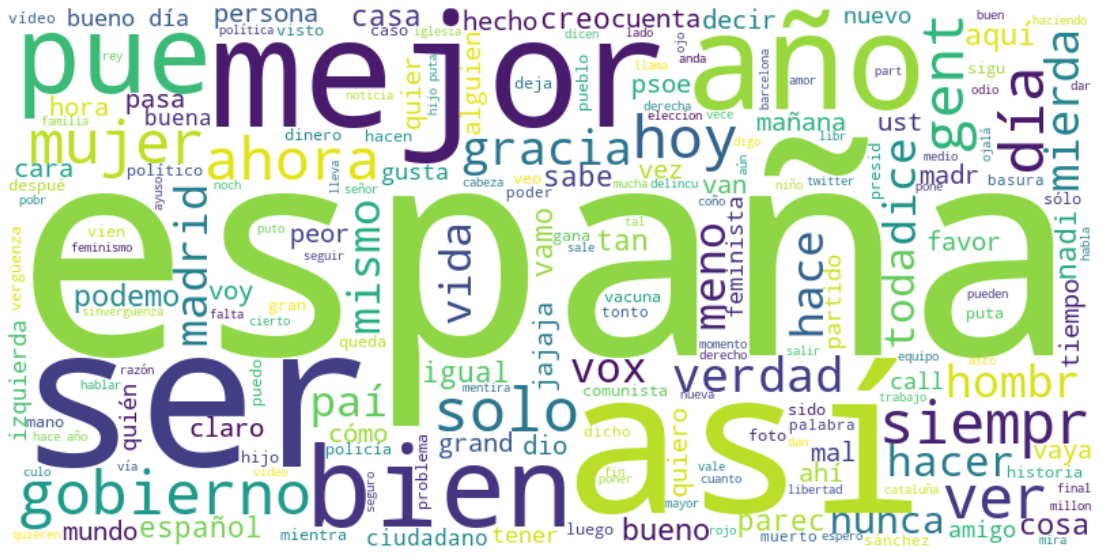

In [ ]:
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt

# Plot the wordcloud of most common tokens in hate spreader authors
wordcloud = WordCloud(stopwords = stopwords_list, background_color = "white", width = 800, height = 400).generate(" ".join(words))

plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# **Train-Test Sets**

We need to split the whole dataset into training and test sets. The first one will be used to fit and select the best candidate model and the second one will be used to evaluate the efficiency of the selected model of every Machine Learning algorithm.

In this case, the proportion of the sets will be:
*   **80%** for training set.
*   **20%** for test set.



In [ ]:
from sklearn.model_selection import cross_val_score, train_test_split 

# Split the whole dataset into train and test sets
tweets_train, tweets_test, label_train, label_test = train_test_split(df['tweets'], df['label'], test_size = 0.2, random_state = 123, stratify = df['label'])

print('Train dataset size\t', len(tweets_train))
print('Test dataset size\t', len(tweets_test))

Train dataset size	 160
Test dataset size	 40


# **Bag of Words and Tf-idf Matrix**

Once we have made a selection of the best words for every author, a corpus will be created containing all the possible words we have in the collection. Then, we will build the **Tf-idf Matrix** to get the relevance of a token in the whole set of documents, in other words, we want to know **if a word is suitable to determinate the label** of a user profile.

To learn more about Tf-idf Matrix: https://en.wikipedia.org/wiki/Tf%E2%80%93idf

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# Get the vocabulary of the tweets
bow = CountVectorizer().fit(tweets_train)

# Learn the Tf-idf model from the training bow
tfidf_transformer = TfidfTransformer().fit(bow.transform(tweets_train))
# Transform the training set to Tf-idf model
tfidf_train = tfidf_transformer.transform(bow.transform(tweets_train))
# Transform the test set to Tf-idf model
tfidf_test = tfidf_transformer.transform(bow.transform(tweets_test))

In [ ]:
# Preview of 10 token from the collection with their identifier
print(list(bow.vocabulary_.items())[:10])
print('\n', str(len(bow.vocabulary_)) + " different tokens have been found in the train set")

[('comun', 6483), ('muert', 19470), ('república', 25052), ('compromiso', 6465), ('libertad', 16996), ('humanidad', 14532), ('ana', 1462), ('díaz', 9927), ('echará', 9973), ('combust', 6226)]

 30776 different tokens have been found in the train set


# **Machine Learning Classification Algorithms**

The final step is fitting a model using the training set we defined before and evaluate the performance with the test set.  The following algorithms will be used to find the best possible model:
*   **Logistic Regression**
*   **Random Forest**
*   **Naive Bayes**
*   **K-Nearest Neighbors**
*   **Decision Tree**
*   **Support Vector Classification**







Every of the previous algorithms needs certain parameters to work. To select the best value for all of them, we will perform **Hyperparameter optimization**. These steps will be done independently of the algorithm used:
1.   Provide a **grid** containing all the parameters can be adjusted in the specific algorithm, and several possible values for every of them.
2.   Perform a **4-fold cross-validation**. That means 3 out ot 4 partitions from the training set will be used to fit the model with every possible combination of the grid and the remaining partition will be used for validation. The average of the 4 predictions will determinate the accuracy for every combination of the grid.
3.   Select the **best combination of parameters**.
4.   **Fit the model** using the train set and the parameter combination selected in step 3.
5.   **Evaluate** the model accuracy and other metrics using the test set.





In [ ]:
import numpy as np
import sklearn.metrics as metrics

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, KFold

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, plot_confusion_matrix

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

This function called `plot_cm` will be used to better visualize the results of the predictions made in the test set. Source code can be found here: https://www.kaggle.com/agungor2/various-confusion-matrix-plots

In [ ]:
def plot_cm(y_true, y_pred, title, figsize=(5,5)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

All the predictions made by the 6 algorithms will be stored here:

In [ ]:
classification_results = tweets_test.copy(deep = True).to_frame()
classification_results['True label'] = label_test

## Logistic Regression

See more about Logistic Regression classifier here: https://en.wikipedia.org/wiki/Logistic_regression

### Model fitting

In [ ]:
param_grid = {'penalty': ['l1', 'l2'],
              'C': np.logspace(-4, 4, 20),
              'solver': ['liblinear', 'lbfgs', 'sag', 'newton-cg']}

model = GridSearchCV(estimator = LogisticRegression(random_state = 123), param_grid = param_grid, cv = KFold(4, random_state = 123), verbose = True, n_jobs = -1)
model.fit(tfidf_train, label_train)
predictions = model.predict(tfidf_test)

Fitting 4 folds for each of 160 candidates, totalling 640 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 640 out of 640 | elapsed:   28.6s finished
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


### Evaluation

In [ ]:
print('Best model:', model.best_params_)

print('Loss:', metrics.log_loss(label_test, predictions))
print('Accuracy:', metrics.accuracy_score(label_test, predictions))
print('Precision:', metrics.precision_score(label_test, predictions, pos_label="1"))
print('Recall:', metrics.recall_score(label_test, predictions, pos_label="1"))
print('f1 score:',metrics.f1_score(label_test, predictions, pos_label="1"))

print('\n', classification_report(label_test, predictions))

Best model: {'C': 545.5594781168514, 'penalty': 'l2', 'solver': 'sag'}
Loss: 12.088711667769024
Accuracy: 0.65
Precision: 0.65
Recall: 0.65
f1 score: 0.65

               precision    recall  f1-score   support

           0       0.65      0.65      0.65        20
           1       0.65      0.65      0.65        20

    accuracy                           0.65        40
   macro avg       0.65      0.65      0.65        40
weighted avg       0.65      0.65      0.65        40



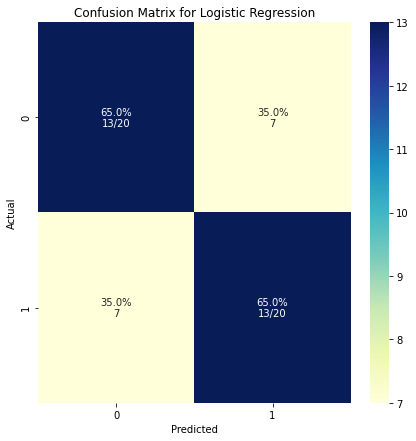

In [ ]:
plot_cm(label_test, predictions, 'Confusion Matrix for Logistic Regression', figsize=(7,7))

In [ ]:
classification_results['Logistic Regression'] = predictions

### Feature Importance

In [ ]:
# 20 most important features
weights = model.best_estimator_.coef_
feature_importance = pd.DataFrame(weights).transpose()
feature_importance.columns = ['weights']
feature_importance['feature'] = bow.get_feature_names()
feature_importance.sort_values(by=['weights', 'feature'], ascending=False).iloc[:20][['feature', 'weights']]

,feature,weights
11254,españa,5.797374
30284,vox,4.878819
19496,mujer,3.817207
14374,hombr,3.705486
13388,gobierno,3.397304
6498,comunista,3.253199
22883,potorra,3.064518
23780,puta,2.998585
15780,jajaja,2.856872
23371,progr,2.821848


## Random Forest

See more about Random Forest classifier here: https://en.wikipedia.org/wiki/Random_forest

### Model fitting

In [ ]:
param_grid = {'n_estimators': list(range(25, 500, 25)),
              'max_features': ['auto', 'sqrt', 'log2'],
              'max_depth': list(range(3, 11)),
              'criterion': ['gini', 'entropy']}

model = GridSearchCV(estimator = RandomForestClassifier(random_state = 123), param_grid = param_grid, cv = KFold(4, random_state = 123), verbose = True, n_jobs = -1)
model.fit(tfidf_train, label_train)
predictions = model.predict(tfidf_test)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 4 folds for each of 912 candidates, totalling 3648 fits


[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 466 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 816 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 1266 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 1816 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done 2466 tasks      | elapsed: 16.4min
[Parallel(n_jobs=-1)]: Done 3216 tasks      | elapsed: 21.8min
[Parallel(n_jobs=-1)]: Done 3648 out of 3648 | elapsed: 25.1min finished


### Evaluation

In [ ]:
print('Best model:', model.best_params_)

print('Loss:', metrics.log_loss(label_test, predictions))
print('Accuracy:', metrics.accuracy_score(label_test, predictions))
print('Precision:', metrics.precision_score(label_test, predictions, pos_label="1"))
print('Recall:', metrics.recall_score(label_test, predictions, pos_label="1"))
print('f1 score:',metrics.f1_score(label_test, predictions, pos_label="1"))

print('\n', classification_report(label_test, predictions))

Best model: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 275}
Loss: 12.088731657704779
Accuracy: 0.65
Precision: 0.6363636363636364
Recall: 0.7
f1 score: 0.6666666666666666

               precision    recall  f1-score   support

           0       0.67      0.60      0.63        20
           1       0.64      0.70      0.67        20

    accuracy                           0.65        40
   macro avg       0.65      0.65      0.65        40
weighted avg       0.65      0.65      0.65        40



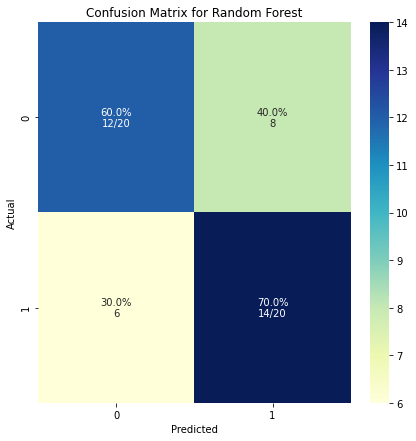

In [ ]:
plot_cm(label_test, predictions, 'Confusion Matrix for Random Forest', figsize=(7,7))

In [ ]:
classification_results['Random Forest'] = predictions

### Feature Importance

In [ ]:
# 20 most important features
weights = model.best_estimator_.feature_importances_
feature_importance = pd.DataFrame(weights)
feature_importance.columns = ['weights']
feature_importance['feature'] = bow.get_feature_names()
feature_importance.sort_values(by=['weights', 'feature'], ascending=False).iloc[:20][['feature', 'weights']]

,feature,weights
13388,gobierno,0.008293
11254,españa,0.006611
11915,extraño,0.006228
23371,progr,0.005764
21517,paí,0.005707
19496,mujer,0.004698
27393,sueño,0.004598
20898,pablo,0.004440
5207,censura,0.004418
24074,quiero,0.004030


## Naive Bayes

See more about Naive Bayes classifier here: https://en.wikipedia.org/wiki/Naive_Bayes_classifier

### Model fitting

In [ ]:
param_grid = {'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 1.0]}

model = GridSearchCV(estimator = MultinomialNB(), param_grid = param_grid, cv = KFold(4, random_state = 123), verbose = True, n_jobs = -1)
model.fit(tfidf_train, label_train)
predictions = model.predict(tfidf_test)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 4 folds for each of 9 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:    0.3s finished


### Evaluation

In [ ]:
print('Best model:', model.best_params_)

print('Loss:', metrics.log_loss(label_test, [int(value) for value in predictions]))
print('Accuracy:', metrics.accuracy_score(label_test, predictions))
print('Precision:', metrics.precision_score(label_test, predictions, pos_label="1"))
print('Recall:', metrics.recall_score(label_test, predictions, pos_label="1"))
print('f1 score:',metrics.f1_score(label_test, predictions, pos_label="1"))

print('\n', classification_report(label_test, predictions))

Best model: {'alpha': 0.001}
Loss: 13.815750437193334
Accuracy: 0.6
Precision: 0.5714285714285714
Recall: 0.8
f1 score: 0.6666666666666666

               precision    recall  f1-score   support

           0       0.67      0.40      0.50        20
           1       0.57      0.80      0.67        20

    accuracy                           0.60        40
   macro avg       0.62      0.60      0.58        40
weighted avg       0.62      0.60      0.58        40



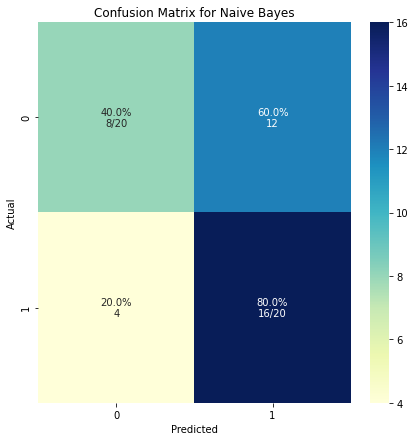

In [ ]:
plot_cm(label_test, predictions, 'Confusion Matrix for Naive Bayes', figsize=(7,7))

In [ ]:
classification_results['Naive Bayes'] = predictions

### Feature Importance

In [ ]:
# 20 most important features
weights = [np.exp(1)**x for x in model.best_estimator_.feature_log_prob_[1]]
feature_importance = pd.DataFrame(weights)
feature_importance.columns = ['weights']
feature_importance['feature'] = bow.get_feature_names()
feature_importance.sort_values(by=['weights', 'feature'], ascending=False).iloc[:20][['feature', 'weights']]

,feature,weights
11254,españa,0.002117
9916,día,0.001793
13388,gobierno,0.001586
17652,madrid,0.001445
26461,ser,0.001418
2916,año,0.001366
30284,vox,0.001353
19496,mujer,0.001347
2493,así,0.001345
23667,pue,0.001306


## K-Nearest Neighbors

See more about K-Nearest Neighbors classifier here: https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm

### Model fitting

In [ ]:
param_grid = {'n_neighbors': list(range(2, 31)),
              'weights': ['uniform', 'distance'],
              'metric': ['euclidean', 'manhattan']}

model = GridSearchCV(estimator = KNeighborsClassifier(), param_grid = param_grid, cv = KFold(4, random_state = 123), verbose = True, n_jobs = -1)
model.fit(tfidf_train,label_train)
predictions = model.predict(tfidf_test)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 4 folds for each of 116 candidates, totalling 464 fits


[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 464 out of 464 | elapsed:   13.5s finished


### Evaluation

In [ ]:
print('Best model:', model.best_params_)

print('Loss:', metrics.log_loss(label_test, predictions))
print('Accuracy:', metrics.accuracy_score(label_test, predictions))
print('Precision:', metrics.precision_score(label_test, predictions, pos_label="1"))
print('Recall:', metrics.recall_score(label_test, predictions, pos_label="1"))
print('f1 score:',metrics.f1_score(label_test, predictions, pos_label="1"))

print('\n', classification_report(label_test, predictions))

Best model: {'metric': 'euclidean', 'n_neighbors': 6, 'weights': 'uniform'}
Loss: 10.361752858087735
Accuracy: 0.7
Precision: 0.7
Recall: 0.7
f1 score: 0.7

               precision    recall  f1-score   support

           0       0.70      0.70      0.70        20
           1       0.70      0.70      0.70        20

    accuracy                           0.70        40
   macro avg       0.70      0.70      0.70        40
weighted avg       0.70      0.70      0.70        40



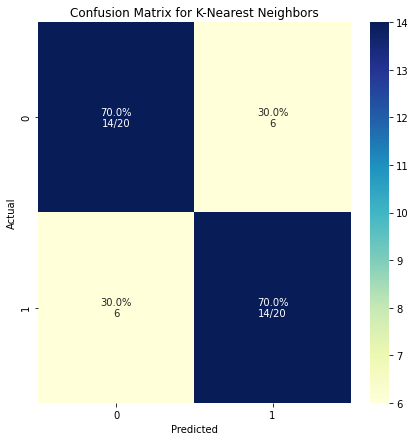

In [ ]:
plot_cm(label_test, predictions, 'Confusion Matrix for K-Nearest Neighbors', figsize=(7,7))

In [ ]:
classification_results['K-Nearest Neighbors'] = predictions

## Decision Tree

See more about Decision Tree classifier here: https://en.wikipedia.org/wiki/Decision_tree_learning

### Model fitting

In [ ]:
param_grid = {'criterion': ['gini', 'entropy'],
              'max_depth': list(range(3, 11)),
              'min_samples_split': list(range(1, 10)),
              'min_samples_leaf': list(range(1, 5))}

model = GridSearchCV(estimator = DecisionTreeClassifier(random_state = 123), param_grid = param_grid, cv = KFold(4, random_state = 123), verbose = True, n_jobs = -1)
model.fit(tfidf_train, label_train)
predictions = model.predict(tfidf_test)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 4 folds for each of 576 candidates, totalling 2304 fits


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 388 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 888 tasks      | elapsed:   37.0s
[Parallel(n_jobs=-1)]: Done 1588 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2304 out of 2304 | elapsed:  1.8min finished


### Evaluation

In [ ]:
print('Best model:', model.best_params_)

print('Loss:', metrics.log_loss(label_test, predictions))
print('Accuracy:', metrics.accuracy_score(label_test, predictions))
print('Precision:', metrics.precision_score(label_test, predictions, pos_label="1"))
print('Recall:', metrics.recall_score(label_test, predictions, pos_label="1"))
print('f1 score:',metrics.f1_score(label_test, predictions, pos_label="1"))

print('\n', classification_report(label_test, predictions))

Best model: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 3, 'min_samples_split': 2}
Loss: 10.361752858087735
Accuracy: 0.7
Precision: 0.7
Recall: 0.7
f1 score: 0.7

               precision    recall  f1-score   support

           0       0.70      0.70      0.70        20
           1       0.70      0.70      0.70        20

    accuracy                           0.70        40
   macro avg       0.70      0.70      0.70        40
weighted avg       0.70      0.70      0.70        40



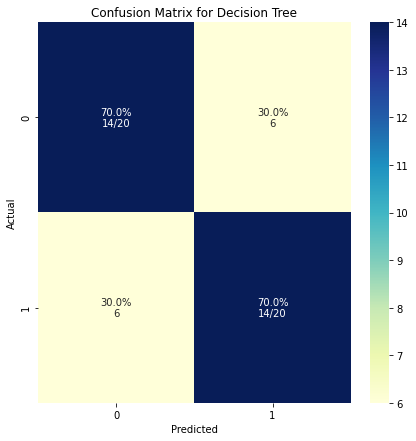

In [ ]:
plot_cm(label_test, predictions, 'Confusion Matrix for Decision Tree', figsize=(7,7))

In [ ]:
classification_results['Decision Tree'] = predictions

### Feature Importance

In [ ]:
# 20 most important features
weights = model.best_estimator_.feature_importances_
feature_importance = pd.DataFrame(weights)
feature_importance.columns = ['weights']
feature_importance['feature'] = bow.get_feature_names()
feature_importance.sort_values(by=['weights', 'feature'], ascending=False).iloc[:20][['feature', 'weights']]

,feature,weights
13388,gobierno,0.341372
1409,amo,0.145288
30284,vox,0.105334
224,acaso,0.098071
9011,despué,0.094780
28475,tonto,0.079302
28204,tierra,0.066742
12335,festejo,0.034556
1089,alerta,0.034556
30775,zúmbate,0.000000


## Support Vector Classification

See more about Support Vector Classification here: https://en.wikipedia.org/wiki/Support-vector_machine

### Model fitting

In [ ]:
param_grid = {'kernel': ['linear', 'rbf'],
              'gamma': [0.0001, 0.001, 0.1, 1],
              'C': [1, 10, 100, 1000]}

model = GridSearchCV(estimator = SVC(random_state = 123), param_grid = param_grid, cv = KFold(4, random_state = 123), verbose = True, n_jobs = -1)
model.fit(tfidf_train, label_train)
predictions = model.predict(tfidf_test)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 4 folds for each of 32 candidates, totalling 128 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:   15.0s finished


### Evaluation

In [ ]:
print('Best model:', model.best_params_)

print('Loss:', metrics.log_loss(label_test, predictions))
print('Accuracy:', metrics.accuracy_score(label_test, predictions))
print('Precision:', metrics.precision_score(label_test, predictions, pos_label="1"))
print('Recall:', metrics.recall_score(label_test, predictions, pos_label="1"))
print('f1 score:',metrics.f1_score(label_test, predictions, pos_label="1"))

print('\n', classification_report(label_test, predictions))

Best model: {'C': 10, 'gamma': 0.0001, 'kernel': 'linear'}
Loss: 12.088711667769024
Accuracy: 0.65
Precision: 0.65
Recall: 0.65
f1 score: 0.65

               precision    recall  f1-score   support

           0       0.65      0.65      0.65        20
           1       0.65      0.65      0.65        20

    accuracy                           0.65        40
   macro avg       0.65      0.65      0.65        40
weighted avg       0.65      0.65      0.65        40



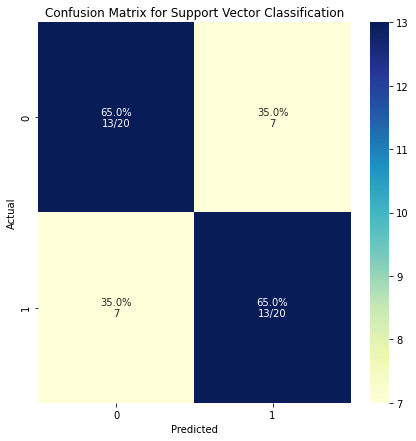

In [ ]:
plot_cm(label_test, predictions, 'Confusion Matrix for Support Vector Classification', figsize=(7,7))

In [ ]:
classification_results['Support Vector Classification'] = predictions

### Feature Importance

In [ ]:
# 20 most important features
weights = model.best_estimator_.coef_[0].toarray()[0]
feature_importance = pd.DataFrame(weights)
feature_importance.columns = ['weights']
feature_importance['feature'] = bow.get_feature_names()
feature_importance.sort_values(by=['weights', 'feature'], ascending=False).iloc[:20][['feature', 'weights']]

,feature,weights
11254,españa,1.060106
30284,vox,0.914129
14374,hombr,0.764207
19496,mujer,0.758663
22883,potorra,0.715868
23780,puta,0.685963
6498,comunista,0.660330
15780,jajaja,0.655919
13388,gobierno,0.625432
21737,pendejo,0.610391


# **Final predictions**

In this table we can see a final recap of the different predictions that all the previous models have returned:

In [ ]:
cols = ['tweets_y', 'True label', 'Logistic Regression', 'Random Forest', 'Naive Bayes', 'K-Nearest Neighbors', 'Decision Tree', 'Support Vector Classification']
pd.merge(classification_results, df_original, left_index=True, right_index=True)[cols].rename(columns={"tweets_y": "Tweets"})

,Tweets,True label,Logistic Regression,Random Forest,Naive Bayes,K-Nearest Neighbors,Decision Tree,Support Vector Classification
25,RT #USER#: #USER# La poca vergüenza que podéi...,1,1,1,1,1,1,1
147,El bloqueador solar que promociona Luciano Ma...,0,0,0,0,0,0,0
43,Esto es ya el colmo de los colmos. #URL# Cuan...,1,1,1,1,1,1,1
168,Cómo que perdió aldosivi. Hace dos partidos q...,0,0,0,0,0,0,0
136,#USER# menudo repaso tu #USER# #USER# yo tamp...,0,0,1,1,0,1,0
81,#USER# #USER# Dieta super calórica. #URL# #US...,0,1,1,1,1,0,1
37,#USER# Siiii Buenas noches guapísima 💋💋 #USER...,1,0,1,1,1,0,0
84,#USER# Soy idiota también 🤫 #USER# Todo arde ...,1,1,1,1,1,1,1
110,RT #USER#: Hola #USER# te dejo este video que...,1,1,1,1,1,1,1
149,Apunta maneras el muchacho #URL# RT #USER#: S...,0,0,0,1,0,0,0
